In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import metrics, model_selection, ensemble
import matplotlib.pyplot as plt

df = pd.read_csv('suumo_treated.csv', sep = '\t', encoding='utf-16', index_col=0)

df = df.drop(29926)
df.head()

,マンション名,区,間取り,間取りDK_LDK,間取りK,間取りS,築年数,建物高さ,階,専有面積,...,駅,賃料,管理費,敷金,礼金,保証金,"敷引,償却",賃料月額,初期費用,年間費用
0,東京メトロ東西線 九段下駅 2階建 築6年,千代田,1,0,0,0,6,2,1,4.33,...,九段下駅,40000,0,0,0,0,0,40000,0,480000
1,La Maison 神田,千代田,1,0,0,0,47,5,5,9.72,...,秋葉原駅,50000,7000,0,0,0,0,57000,0,684000
2,番町ハイム,千代田,1,0,0,0,46,11,3,15.37,...,麹町駅,50000,7000,50000,50000,0,0,57000,100000,784000
3,番町ハイム,千代田,1,0,0,0,46,11,11,15.37,...,麹町駅,60000,10000,60000,60000,0,0,70000,120000,960000
4,番町ハイム,千代田,1,0,0,0,46,11,8,21.31,...,麹町駅,60000,6000,60000,60000,0,0,66000,120000,912000


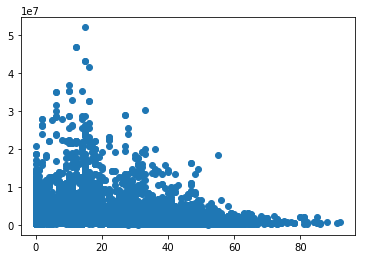

In [2]:

#df.to_csv('suumo_treated.csv', sep = '\t',encoding='utf-16')
df = df.drop(df.index[df['築年数'] == 99])

plt.scatter(df['築年数'], df['年間費用'])

In [3]:
df = df.drop([69267, 69266, 199848, 76041])
df = df.dropna()

In [4]:
ward = pd.get_dummies(df['区'])

df = pd.merge(df, ward, left_index=True, right_index=True)

In [5]:
df_extract = df
target = df_extract['年間費用'].astype(np.float32)
df_extract.drop(['マンション名','区','路線', '駅', '賃料','管理費','敷金','礼金','保証金','敷引,償却', '賃料月額', '初期費用', '年間費用'], axis=1, inplace=True) 
data = df_extract.astype(np.float32)


In [6]:
import tensorflow as tf
from sklearn import preprocessing

# normalize
#df = df.iteritems(lambda x: df)
#df = df.apply(lambda x: (x - np.av/(np.max(x) - np.min(x)))
x = data.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_n = pd.DataFrame(x_scaled, columns=data.columns)
df_n.head()

,間取り,間取りDK_LDK,間取りK,間取りS,築年数,建物高さ,階,専有面積,歩分,世田谷,...,江戸川,江東,渋谷,港,目黒,練馬,荒川,葛飾,豊島,足立
0,0.0,0.0,0.0,0.0,0.065217,0.016393,0.119403,0.011236,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.510870,0.065574,0.179104,0.025554,0.012739,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.500000,0.163934,0.149254,0.040562,0.002123,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.500000,0.163934,0.268657,0.040562,0.002123,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.500000,0.163934,0.223881,0.056341,0.002123,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
target_n = (target - target.min())/(target.max() - target.min()) 

In [8]:
len(df_n.columns)

32

In [20]:
# declare placeholder
x = tf.placeholder(tf.float32, [None, 32])
y_ = tf.placeholder(tf.float32, [None,1])

# declare variables
# len(df.columns) -> [None, 10]
w1 = tf.Variable(tf.random_normal([32, 10], stddev=0.1))
b1 = tf.Variable(tf.zeros([10]))
w2 = tf.Variable(tf.random_normal([10, 1], stddev=0.1))
b2 = tf.Variable(tf.zeros([1]))

# first layer
y1 = tf.nn.sigmoid(tf.matmul(x, w1) + b1)
y2 = tf.nn.sigmoid(tf.matmul(y1,w2) + b2)

# train model
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_, logits=y2) )

optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

# accuracy
cost = tf.reduce_mean(tf.square(y_ - y2))


In [21]:
target_n = target_n.reshape(206250, 1)

In [22]:
train_data = df_n[0:160000]
train_target = target_n[0:160000]
test_data = df_n[160001:]
test_target = target_n[160001:]

In [23]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

for step in range(20000):
    i = (step * 5000) % 155000
    x_train = train_data[i + 1: i + 5000]
    y_train = train_target[i + 1: i + 5000]
    sess.run(train, feed_dict={x: x_train, y_: y_train})
    if step % 1000 == 0 :
        lost_out = sess.run(loss, feed_dict={x: x_train, y_: y_train })
        err = sess.run(cost, feed_dict={x: test_data, y_: test_target} )
        print("step = ", step, " entropy= ", lost_out, " cost= ", err)

err = sess.run(cost, feed_dict={x:test_data, y_:test_target})
print("Final cost= ", err)


Instructions for updating:
Use `tf.global_variables_initializer` instead.
step =  0  entropy=  0.992172  cost=  0.292903
step =  1000  entropy=  0.729015  cost=  0.00313829
step =  2000  entropy=  0.708028  cost=  0.000330374
step =  3000  entropy=  0.703011  cost=  8.60166e-05
step =  4000  entropy=  0.699509  cost=  7.17556e-05
step =  5000  entropy=  0.698627  cost=  9.34007e-05
step =  6000  entropy=  0.697441  cost=  0.000119178
step =  7000  entropy=  0.696721  cost=  0.000142693
step =  8000  entropy=  0.695999  cost=  0.000162919
step =  9000  entropy=  0.695931  cost=  0.00018009
step =  10000  entropy=  0.695519  cost=  0.000194675
step =  11000  entropy=  0.695255  cost=  0.000207138
step =  12000  entropy=  0.695258  cost=  0.000217869
step =  13000  entropy=  0.695156  cost=  0.000227184
step =  14000  entropy=  0.694722  cost=  0.000235326
step =  15000  entropy=  0.694782  cost=  0.000242499
step =  16000  entropy=  0.694703  cost=  0.000248856
step =  17000  entropy=  0

In [34]:
from sklearn.externals import joblib

joblib.dump(clf, 'suumo_rent.pkl')

NameError: name 'clf' is not defined

In [116]:

test_reindex = pd.merge(data_test, label_test.to_frame(), left_index=True, right_index=True)
test_reindex = test_reindex.sort_values(by='年間費用').reset_index()

del test_reindex['index']

test_reindex.head()

,間取り,間取りDK_LDK,間取りK,間取りS,築年数,建物高さ,階,専有面積,歩分,世田谷,...,江東,渋谷,港,目黒,練馬,荒川,葛飾,豊島,足立,年間費用
0,1,0,0,0,50,3,3,9.61,13.0,0,...,1,0,0,0,0,0,0,0,0,240000
1,1,0,0,0,44,2,1,9.00,8.0,0,...,0,0,0,0,0,0,0,0,0,240000
2,1,0,0,0,51,2,2,9.72,7.0,0,...,0,0,0,0,0,0,0,0,0,258000
3,1,0,1,0,42,2,2,13.93,7.0,0,...,0,0,0,0,0,0,0,0,0,260000
4,1,0,0,0,49,2,2,13.77,7.0,0,...,0,0,0,0,0,0,0,0,0,260000


In [117]:
plt.plot(test_reindex.index, test_reindex['年間費用'])


In [118]:
Y  = test_reindex['年間費用']
del test_reindex['年間費用']
X = test_reindex

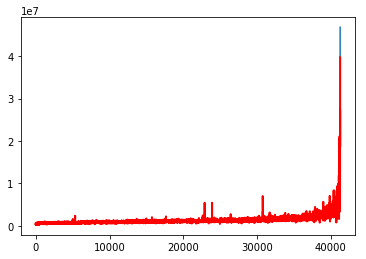

In [119]:
plt.plot(X.index, clf.predict(X), color='red', linewidth=2)
plt.show()

In [121]:
residual_RF = (Y-clf.predict(X))**2
residual_RF_total = residual_RF.sum()
#print(mean_absolute_error(Y, clf.predict(X)))
print(residual_RF_total)

3128321517568509.0


In [67]:
from sklearn import linear_model

clf_LR = linear_model.LinearRegression(normalize=True)
clf_LR.fit(data_train, label_train)

print(data_train)


       間取り  間取りDK_LDK  間取りK  間取りS  築年数  建物高さ   階   専有面積    歩分  世田谷 ...  江戸川  \
53571    2          1     0     0   11    15  14  38.75   8.0    0 ...    0   
13747    1          0     0     0   28     7   3  20.21   5.0    0 ...    0   
132601   1          0     1     0    9     7   1  20.28   7.0    0 ...    0   
92418    1          0     1     0   21     2   2  20.52   6.0    1 ...    0   
152100   2          1     0     0   40     5   3  41.00   5.0    0 ...    0   
88593    1          0     1     0   19     2   2  24.50   5.0    1 ...    0   
18988    1          0     1     0    0     7   3  25.37   6.0    0 ...    0   
25143    1          0     1     0   14     4   4  20.20   5.0    0 ...    0   
183032   1          0     1     0    0     9   3  21.23   8.0    0 ...    0   
112488   3          1     0     0   22     7   4  65.50   7.0    0 ...    0   
185165   2          1     0     0   17     2   1  42.00  10.0    0 ...    0   
48996    1          0     1     0   12     8   2  24

In [68]:
residual_LR = (Y-clf_LR.predict(X))**2
residual_LR_total = residual_LR.sum()
print(residual_LR_total)

1.5062279482224816e+16


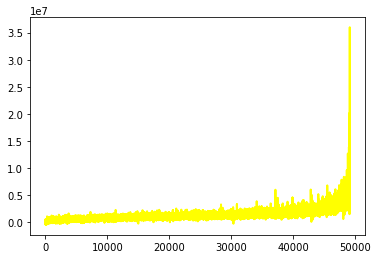

In [69]:
plt.plot(X.index, clf_LR.predict(X), color='yellow', linewidth=2)
plt.show()